##**Business** **Understanding**
This project introduces a Random Forest, designed to forecast if a customer will engage with an offer dispatched by a business in the Retail Industry.

The project provides insights into the following.
*   Is a customer likely to react to an offer circulated by the business?



## **Data** **Understanding**

**Importing** **Libraries**

In [45]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV

**Importing** **Data**

In [46]:
portfolio = pd.read_json('/content/portfolio.json', orient='records', lines=True)
profile = pd.read_json('/content/profile.json', orient='records', lines=True)
transcript = pd.read_json('/content/transcript.json', orient='records', lines=True)

In [47]:
portfolio.head()


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [48]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [49]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [50]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [51]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [52]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


## **Prepare** **Data**

In [53]:
list(transcript.value.iloc[12658].keys())

['offer_id', 'reward']

In [54]:
#to find out the types of events
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

**Prepare data: clean process (transcript df)**
In this dataframe we can apply the following modifications:

we can separate the column value into three more columns: "offer_id", "amount" e "reward"
we can separate the column value into three more columns (one hot encoding): "offer_received", "offer_viewed", "transaction" e "offer_completed"

In [55]:
# we have three different keys in the value column (dictionary): offer_id, amount and reward
# let's create functions to extract data from these dictionaries' keys

def expand_transcript_offer_id():
    '''
    this function extract the data: "offer_id" from the value column
    '''
    offer_id_list = []

    for dic in transcript.value.iloc[0:]:
        if 'offer id' in list(dic.keys()):
            offer_id_list.append(dic['offer id'])
        elif 'offer_id' in list(dic.keys()):
            offer_id_list.append(dic['offer_id'])
        else:
            offer_id_list.append(np.nan)

    return offer_id_list

def expand_transcript_amount(entry):
    '''
    this function extract the data: "amount" from the value column
    '''
    try:
        if type(entry['amount']) == float or int:
            return entry['amount']
    except:
        return np.nan

def expand_transcript_reward(entry):
    '''
    this function extract the data: "reward" from the value column
    '''
    try:
        if type(entry['reward']) == float or int:
            return entry['reward']
    except:
        return np.nan

In [56]:
def expand_transcript_all(transcript=transcript):
    '''
    this function use the following functions:
    - expand_transcript_offer_id()
    - expand_transcript_amount(entry)
    - expand_transcript_reward(entry)
    to create new columns in the transcript dataframe from the data in the value column
    '''

    # then we create three new columns
    offer_id_list = expand_transcript_offer_id()
    transcript['offer_id'] = offer_id_list
    transcript['amount'] = transcript['value'].apply(lambda x: expand_transcript_amount(x))
    transcript['reward'] = transcript['value'].apply(lambda x: expand_transcript_reward(x))

    # and then drop the "value" column
    transcript.drop(columns=["value"], inplace=True)
    return transcript

transcript = expand_transcript_all(transcript=transcript)


In [57]:
transcript.head()

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


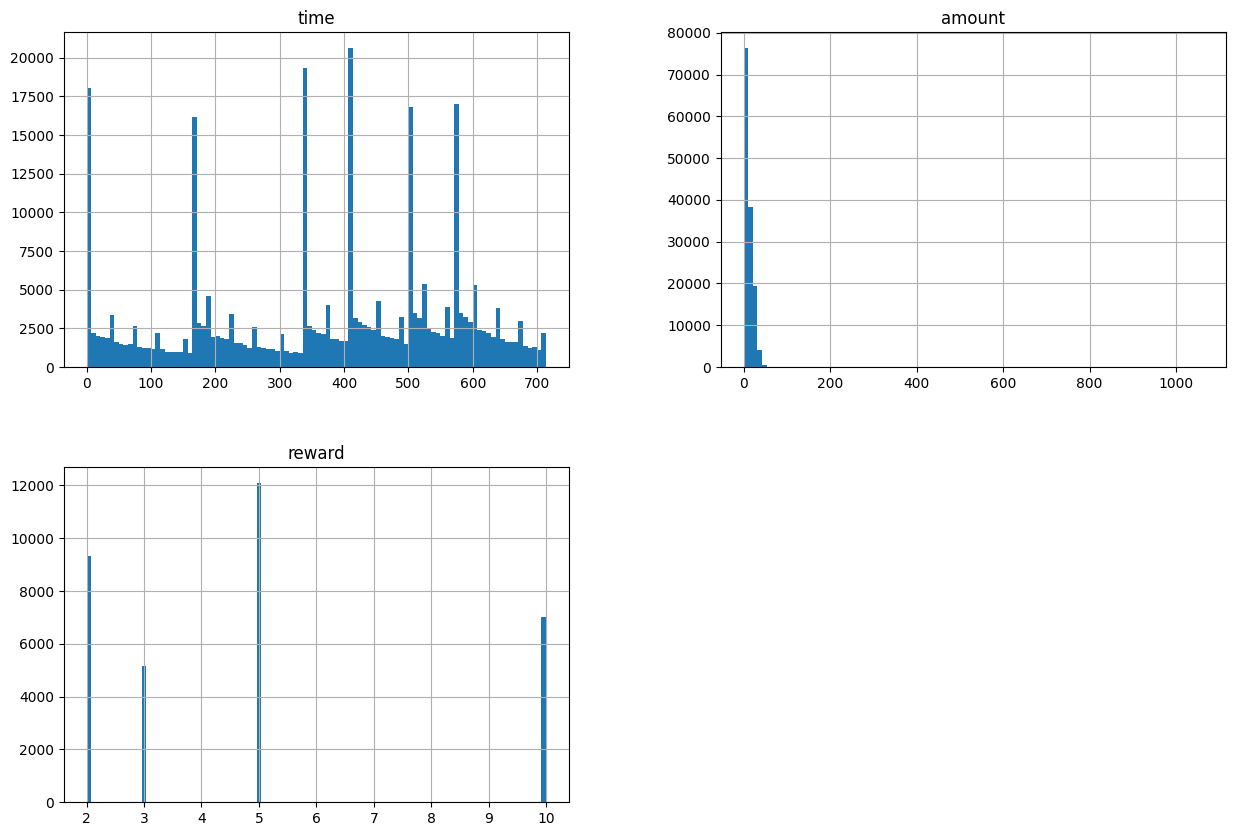

In [58]:
transcript.hist(bins=100, figsize=(15, 10));

In [59]:
# we can see that one person can have more than one transaction (event) and there are 17000 clients
len(transcript), len(transcript.person.unique())

(306534, 17000)

In this dataset we have information of the user's transactions and the offers the users receive. So, we can inquire which offers the users received, viewed and completed and which they just received and didn't used. It can be interesting if we apply one hot encoding to each event: received, viewed and completed. So, we will separate the dataset by event and then merge to apply one hot encoding.

We also have the event: transaction. Using this event we can see the number of transactions of each user and the total amount the users have spent. This information can be valuable to complement the profile dataset.

In [60]:
def separate_transcript(transcript=transcript):
    '''
    this function separates the transcript df into 4 df according to
    the 4 types of events
    '''
    # the received df just tells us that a user received an offer
    # so, it doesn't have amount and reward information, let's drop
    received = transcript[transcript['event'] == "offer received"]
    received.drop(columns=['amount', 'reward'], inplace=True)

    # the received df just tells us that a user viewed an offer
    # so, it doesn't have amount and reward information, let's drop
    viewed = transcript[transcript['event'] == "offer viewed"]
    viewed.drop(columns=['amount', 'reward'], inplace=True)

    # the completed df tells us that a user completed (responded to) an offer
    # so, it just have reward information, let's drop amount column
    completed = transcript[transcript['event'] == "offer completed"]
    completed.drop(columns=['amount'], inplace=True)

    # the transaction df tells us the amount of each transaction
    # so, itjust have amount information, let's drop offer_id and reward columns
    transaction = transcript[transcript['event'] == "transaction"]
    transaction.drop(columns=['offer_id', 'reward'], inplace=True)

    #change the columns' names
    received.columns = ['customer_id', 'event', 'time', 'offer_id']
    viewed.columns = ['customer_id', 'event', 'time', 'offer_id']
    completed.columns = ['customer_id', 'event', 'time', 'offer_id', 'reward']
    transaction.columns = ['customer_id', 'event', 'time', 'amount']

    return received, viewed, completed, transaction

received, viewed, completed, transaction = separate_transcript(transcript=transcript)

<ipython-input-60-c1f3097f8827>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  received.drop(columns=['amount', 'reward'], inplace=True)
<ipython-input-60-c1f3097f8827>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viewed.drop(columns=['amount', 'reward'], inplace=True)
<ipython-input-60-c1f3097f8827>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  completed.drop(columns=['amount'], inplace=True)
<ipython-input-60-c1f3097f8827>

In [61]:
def one_hot_events(received=received, viewed=viewed, completed=completed):
    '''
    this function creates a new column with one values according to the event
    and then merge the dataframes
    '''
    # column with 1 value
    received['offer_received'] = 1
    viewed['offer_viewed'] = 1
    completed['offer_completed'] = 1

    # merge the three dfs
    event_df = received.merge(
        viewed, how="left", on=['customer_id', "offer_id"]).merge(
        completed, how="left", on=['customer_id', "offer_id"])
    event_df.drop(columns=["event_x", "event_y", "event"], inplace=True)
    event_df.columns = ['customer_id', 'time_received', 'offer_id', 'offer_received',
                        'time_viewed', 'offer_viewed', 'time_completed', 'reward', 'offer_completed']

    return event_df

In [62]:
event_df = one_hot_events(received=received, viewed=viewed, completed=completed)

<ipython-input-61-700b5eabca30>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  received['offer_received'] = 1
<ipython-input-61-700b5eabca30>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  viewed['offer_viewed'] = 1
<ipython-input-61-700b5eabca30>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [63]:
def clean_event_df(event_df=event_df):
    '''
    this function will create a dataframe that indicate whether or not the
    customer responded to an offer with binary data. Columns:
    *customer_responded:
    1 - the customer viewed and completed the offer
    0 - the customer viewed but didn't used the offer
    *customer_id
    *offer_id
    '''
    event_df = event_df[event_df['offer_viewed'] == 1]

    # we replace the nan with 1000 to then apply the customer_responded
    # function
    event_df.time_completed = event_df.time_completed.fillna(1000)

    def customer_responded(event_df=event_df):
        '''
        This function returns the values 0, 1 or nan depending on the values
        of the 'time_completed' and 'time_viewed' columns
        '''
        if event_df['time_completed'] == 1000:
            return 0
        elif event_df['time_completed'] > event_df['time_viewed']:
            return 1
        else:
            return np.nan

    # we create a new column applying the customer_responded function
    event_df['customer_responded'] = event_df.apply(customer_responded, axis=1)

    # drop customers who viewed the offer after completed it
    event_df.dropna(subset=['customer_responded'], inplace=True)

    # replace 1000 with nan again
    event_df.time_completed = event_df.time_completed.replace(1000, np.nan)

    # drop the columns that we won't use to build the ML model
    event_df.drop(columns=['time_received','offer_received','time_viewed','offer_viewed',
                          'time_completed','reward','offer_completed'], inplace=True)

    return event_df

In [65]:
event_df = clean_event_df(event_df=event_df)

<ipython-input-63-cb38ea87b8e4>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_df.time_completed = event_df.time_completed.fillna(1000)
<ipython-input-63-cb38ea87b8e4>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_df['customer_responded'] = event_df.apply(customer_responded, axis=1)
<ipython-input-63-cb38ea87b8e4>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [66]:
event_df.head()

,customer_id,offer_id,customer_responded
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
2,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0
3,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0.0
4,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,0.0


**Explore: Portfolio (offers' data**

In [67]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [68]:
portfolio.shape

(10, 6)

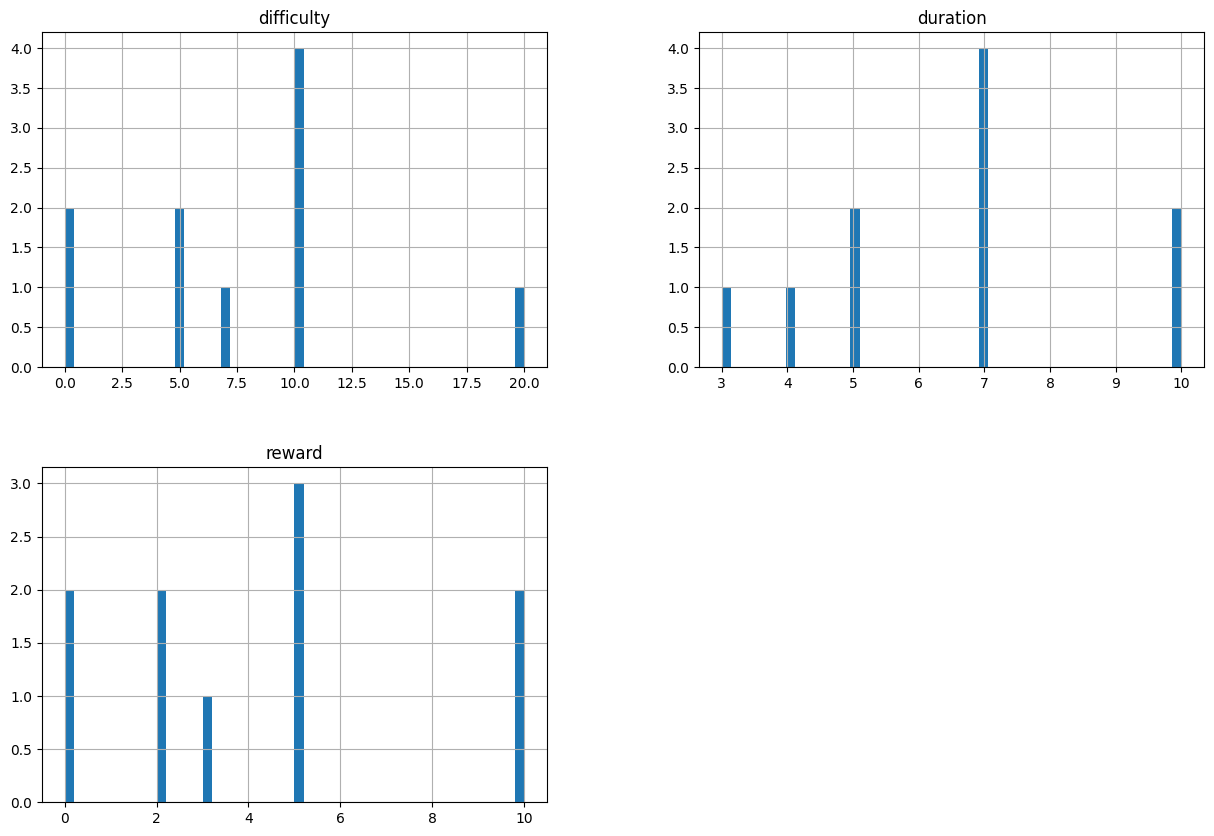

In [70]:
portfolio[['difficulty', 'duration', 'reward']].hist(bins=50, figsize=(15, 10));

**Clean process - Portfolio df**

In [71]:
def one_hot_channels_offer_type(portfolio=portfolio):
    '''
    this function applies one hot encoding in the channels column of the portfolio df
    '''
    channels_list = ['web', 'email', 'mobile', 'social']
    portfolio['web_channel'] = portfolio['channels'].apply(lambda x: 1 if channels_list[0] in x else 0)
    portfolio['email_channel'] = portfolio['channels'].apply(lambda x: 1 if channels_list[1] in x else 0)
    portfolio['mobile_channel'] = portfolio['channels'].apply(lambda x: 1 if channels_list[2] in x else 0)
    portfolio['social_channel'] = portfolio['channels'].apply(lambda x: 1 if channels_list[3] in x else 0)

    # drop the channels columns
    portfolio.drop(columns=["channels"], inplace=True)

    # one hot offer_type
    try:
        portfolio = pd.get_dummies(portfolio, columns=['offer_type'], prefix="offer_type_")
    except:
        pass

    portfolio.columns = ['reward', 'difficulty', 'duration', 'offer_id', 'web_channel', 'email_channel',
                     'mobile_channel', 'social_channel', 'offer_type__bogo','offer_type__discount',
                     'offer_type__informational']

    return portfolio

portfolio = one_hot_channels_offer_type(portfolio=portfolio)

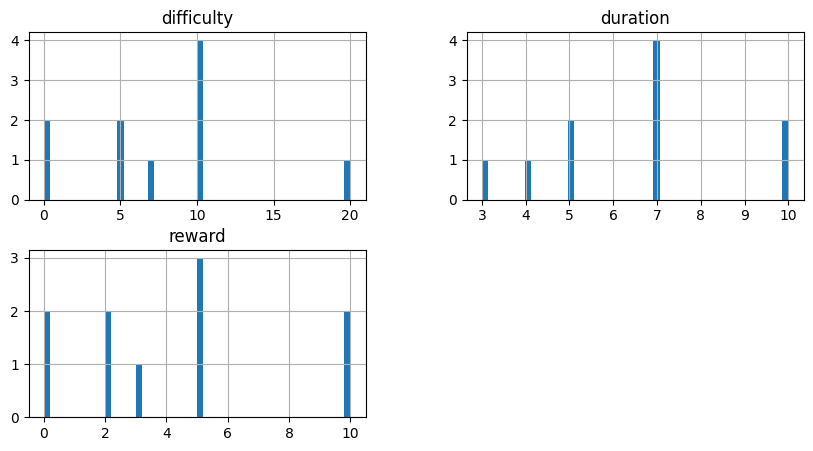

In [72]:
portfolio[['difficulty', 'duration', 'reward']].hist(bins=50, figsize=(10, 5));

In [73]:
portfolio.head()

,reward,difficulty,duration,offer_id,web_channel,email_channel,mobile_channel,social_channel,offer_type__bogo,offer_type__discount,offer_type__informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,True,False,False
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,True,False,False
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,False,False,True
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,True,False,False
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,False,True,False


**Explore: Profile (customer's data)**

In [74]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [75]:
profile.age.describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [76]:
(profile['age'] == 118).sum()/len(profile), profile['income'].isna().sum()/len(profile)

(0.12794117647058822, 0.12794117647058822)

**Prepare data: clean process (profile df)**
We can see that the percentage of people who didn't inform age is the same as people who didn't inform their income and their gender as well. And, since this percentage is relatively small (13%) it makes sense if we drop the these rows, because we're not going to lose too much information.

In [77]:
def modify_profile(profile=profile):
    try:
        profile = pd.get_dummies(profile, columns=['gender'], dummy_na=False, prefix="gender_")
    except:
        pass

    profile.became_member_on = pd.to_datetime(profile.became_member_on.apply(str), format='%Y%m%d')

    profile['now'] = pd.to_datetime('now')
    profile['days_as_member'] = (profile['now'] - profile['became_member_on']).dt.days
    profile.drop(columns=['became_member_on', 'now'], inplace=True)

    # drop nan
    profile.dropna(subset=['income'], inplace=True)

    return profile

profile = modify_profile()
profile.head()

,age,id,income,gender__F,gender__M,gender__O,days_as_member
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,True,False,False,2523
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,True,False,False,2590
5,68,e2127556f4f64592b11af22de27a7932,70000.0,False,True,False,2238
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,False,True,False,2314
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,False,True,False,2404


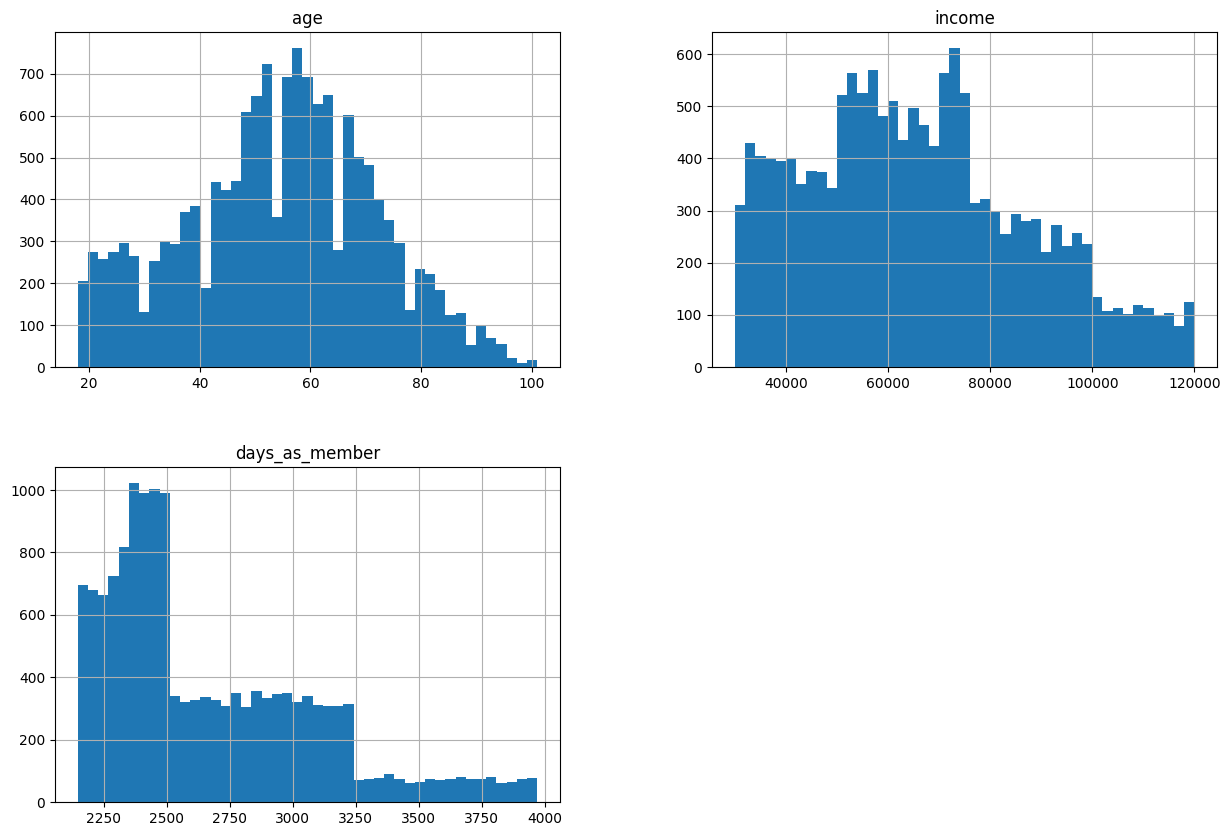

In [82]:
profile[['age', 'income', 'days_as_member']].hist(bins=45, figsize=(15, 10));


In [83]:
# we can use the transactions df that we extracted from the transcript df to add valuable
# information to the profile df, which contains customer's data
transaction.head()

,customer_id,event,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,18.97


**Prepare data: merge data (transcript df)**

We're going to calculate the number of transactions per user and the total amount per user. This information will be valuable to add to the profile df:


*   Number of transactions
*   Total amount

In [84]:
def merge_profile_df(profile=profile, transaction=transaction):
    '''
    this function merge the profile df with data from transaction df. Columns:
    - age: customer's age
    - customer_id
    - income: customer's income
    - gender: M, F, O with one-hot-encoding
    - days_as_member: time in days using the app
    - number_of_transactions: total transactions using the app
    - total_amount: total amount of money spent on the app
    '''
    # number of transactions per customer
    number_of_transactions = pd.DataFrame(
        transaction.groupby(['customer_id']).size(), columns=['number_of_transactions']).reset_index(level=0)
    number_of_transactions.columns = ['customer_id', 'number_of_transactions']

    # merge the number of transactions on customer_id
    profile.columns = ['age', 'customer_id', 'income', 'gender__F', 'gender__M', 'gender__O', 'days_as_member']
    profile = profile.merge(number_of_transactions, how='left', on='customer_id')

    # total amount spent per customer
    total_amount = pd.DataFrame(transaction.groupby(['customer_id']).sum()['amount'])
    total_amount = total_amount.reset_index(level=0)
    total_amount.columns = ['customer_id', 'total_amount']

    # merge the total_amount on customer_id
    profile = profile.merge(total_amount, how='left', on='customer_id')

    return profile

In [85]:
profile = merge_profile_df(profile=profile, transaction=transaction)
profile.head()

,age,customer_id,income,gender__F,gender__M,gender__O,days_as_member,number_of_transactions,total_amount
0,55,0610b486422d4921ae7d2bf64640c50b,112000.0,True,False,False,2523,3.0,77.01
1,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,True,False,False,2590,7.0,159.27
2,68,e2127556f4f64592b11af22de27a7932,70000.0,False,True,False,2238,3.0,57.73
3,65,389bc3fa690240e798340f5a15918d5c,53000.0,False,True,False,2314,3.0,36.43
4,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,False,True,False,2404,4.0,15.62


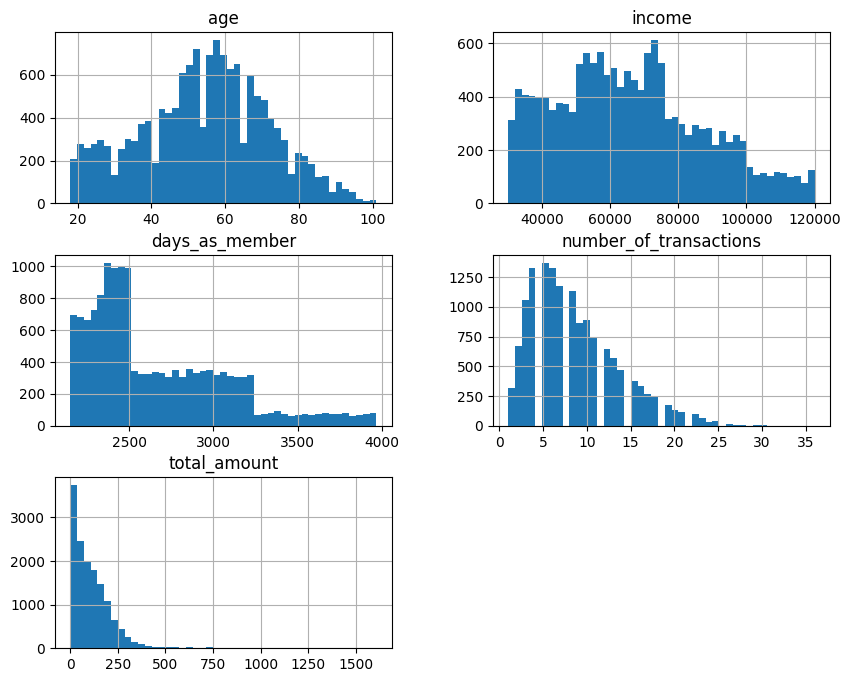

In [88]:
profile[['age', 'income', 'days_as_member', 'number_of_transactions', 'total_amount']].hist(bins=45, figsize=(10, 8));

**Merge all dataframes**

In [89]:
df = event_df.merge(profile, how='left', on='customer_id').dropna()

In [90]:
df = df.merge(portfolio, how='left', on='offer_id')

In [91]:
df.head()

,customer_id,offer_id,customer_responded,age,income,gender__F,gender__M,gender__O,days_as_member,number_of_transactions,...,reward,difficulty,duration,web_channel,email_channel,mobile_channel,social_channel,offer_type__bogo,offer_type__discount,offer_type__informational
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,75.0,100000.0,True,False,False,2590.0,7.0,...,5,5,7,1,1,1,0,True,False,False
1,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,0.0,68.0,70000.0,False,True,False,2238.0,3.0,...,2,10,7,1,1,1,0,False,True,False
2,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1.0,65.0,53000.0,False,True,False,2314.0,3.0,...,5,5,5,1,1,1,1,True,False,False
3,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1.0,65.0,53000.0,False,True,False,2314.0,3.0,...,5,5,5,1,1,1,1,True,False,False
4,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d,1.0,65.0,53000.0,False,True,False,2314.0,3.0,...,5,5,5,1,1,1,1,True,False,False


In [93]:
# Checking the data is balanced or not
df.customer_responded.sum() / len(df)

0.5952205162204107

# **Data Modeling**

In [94]:
int_cols = ['age', 'income', 'gender__F', 'gender__M', 'gender__O', 'days_as_member',
     'number_of_transactions', 'reward', 'difficulty', 'duration', 'web_channel',
     'email_channel', 'mobile_channel', 'social_channel', 'offer_type__bogo',
     'offer_type__discount', 'offer_type__informational']

In [95]:
df.columns[3:]

Index(['age', 'income', 'gender__F', 'gender__M', 'gender__O',
       'days_as_member', 'number_of_transactions', 'total_amount', 'reward',
       'difficulty', 'duration', 'web_channel', 'email_channel',
       'mobile_channel', 'social_channel', 'offer_type__bogo',
       'offer_type__discount', 'offer_type__informational'],
      dtype='object')

In [96]:
X = df[df.columns[3:]]
X[int_cols] = X[int_cols].astype(int)
y = df['customer_responded'].astype('category')

<ipython-input-96-8bbcfd217583>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[int_cols] = X[int_cols].astype(int)


In [97]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, shuffle=True)

In [98]:
clf = RandomForestClassifier()
clf.fit(train_X, train_y)

RandomForestClassifier()

In [99]:
pred = clf.predict(val_X)
pred

array([1., 0., 1., ..., 1., 1., 1.])

# **Evaluate the Model**

In [100]:
accuracy = accuracy_score(val_y, pred)
print('Accuracy: ', accuracy)

Accuracy:  0.930026518804243


In [101]:
print(classification_report(val_y,pred))

              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91      6666
         1.0       0.92      0.96      0.94      9926

    accuracy                           0.93     16592
   macro avg       0.93      0.92      0.93     16592
weighted avg       0.93      0.93      0.93     16592



# **Hyperparameter tuning**

In [103]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 4)]
max_depth.append(None)
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [50, 200, 350, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 43, 76, 110, None], 'bootstrap': [True, False]}


In [104]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=10, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_X, train_y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 43, 76, 110, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [50, 200, 350, 500]},
                   random_state=42, verbose=10)

**Evaluate the tuned mode**

In [105]:
pred2 = rf_random.predict(val_X)
pred2

array([1., 0., 1., ..., 1., 1., 1.])

In [106]:
accuracy2 = accuracy_score(val_y, pred2)
print('Accuracy of tuned model: ', accuracy2)

Accuracy of tuned model:  0.9314729990356798


In [107]:
print(classification_report(val_y,pred2))

              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91      6666
         1.0       0.92      0.97      0.94      9926

    accuracy                           0.93     16592
   macro avg       0.93      0.92      0.93     16592
weighted avg       0.93      0.93      0.93     16592



In [108]:
print('Accuracy improvement of: {0:.3g} % with hyperparameter tuning (GridSearchCV)'.format((accuracy2-accuracy)*100))

Accuracy improvement of: 0.145 % with hyperparameter tuning (GridSearchCV)


In [109]:
accuracy3 = balanced_accuracy_score(val_y, pred2)
print('Balanced accuracy of tuned model: ', accuracy3)

Balanced accuracy of tuned model:  0.923240092496052


# **Conclusions**
1. The data preprocessing methods allowed us to build a highly accurate model

2.The Random Forest Regressor classifier algorithm showed to be effective for the binary classification in this business case since the base model showed an accuracy of 92.5% and precision, recall and f1-score metrics almost all over 90%

3. Performing hyperparameter tuning improved the model accuracy in 0.344%